In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
sofa_score = pd.read_csv('sofa_scores.csv')

In [4]:
all_subgroups = pd.read_csv('all_subgroups.csv')
#all_subgroups = all_subgroups[['subject_id', 'hadm_id', 'subgroup', 'rounded_age']]
temp = pd.read_csv('chartevents_temp_cleaned.csv')
temp = temp[temp['hadm_id'].isin(all_subgroups['hadm_id'].value_counts().index)][['hadm_id', 'Final_Temperature_F', 'charttime']]
#temp = temp[temp['charttime'].isin(all_subgroups['charttime'].value_counts().index)][['hadm_id', 'Final_Temperature_F', 'charttime']]
bp = pd.read_csv('chartevents_bp_cleaned.csv')
bp = bp[bp['hadm_id'].isin(all_subgroups['hadm_id'].value_counts().index)][['hadm_id', 'Combined_Blood_Pressure', 'charttime']].dropna()
def impute(heart_rate, max_rate):
    if pd.isna(heart_rate) == True:
        return max_rate
    else:
        return heart_rate
heart_rate = pd.read_csv('chartevents_hr_cleaned.csv')
heart_rate['heart_rate'] = heart_rate.apply(lambda x: impute(x["Heart Rate"], x["Heart rate Alarm - High"]), axis=1)
heart_rate = heart_rate[['hadm_id', 'charttime', 'heart_rate']]
o2_state = pd.read_csv('chartevents_o2sat.csv')
o2_state = o2_state[['hadm_id', 'charttime', 'SpO2']]
respiritory_rate = pd.read_csv('chartevents_rr_cleaned.csv')
respiritory_rate = respiritory_rate[['hadm_id', 'charttime', 'RespiratoryRate_combined']]
white_blood_cell = pd.read_csv('chartevents_wbc_cleaned.csv')
white_blood_cell = white_blood_cell[['hadm_id', 'charttime', 'WBC_combined']]

In [5]:
model_subgroups = all_subgroups[['subject_id', 'hadm_id', 'subgroup', 'rounded_age']]

In [6]:
df = model_subgroups.merge(bp, on = 'hadm_id', how = 'outer')

In [7]:
df = df.merge(temp, on = ['charttime', 'hadm_id'], how = 'left')

In [8]:
df = df.merge(heart_rate, on = ['charttime', 'hadm_id'], how = 'left')


In [9]:
df = df.merge(respiritory_rate, on = ['charttime', 'hadm_id'], how = 'left')

In [10]:
df = df.merge(o2_state, on = ['charttime', 'hadm_id'], how = 'left')

In [11]:
df = df.dropna()

In [12]:

df['date'] = pd.to_datetime(df['charttime']).dt.date
df['charttime'] = pd.to_datetime(df['charttime'])

In [13]:
df.isna().sum()

subject_id                  0
hadm_id                     0
subgroup                    0
rounded_age                 0
Combined_Blood_Pressure     0
charttime                   0
Final_Temperature_F         0
heart_rate                  0
RespiratoryRate_combined    0
SpO2                        0
date                        0
dtype: int64

In [14]:
#accounts for readmission 
df['hadm_number'] = df.groupby('subject_id')['hadm_id'].rank(method='dense').astype(int)

In [15]:
df_sorted = df.sort_values(by=['subject_id', 'hadm_id', 'charttime'])

# Define a function to assign hours
def assign_hours(group):
    group['hours_in_hospital'] = (group['charttime'] - group['charttime'].iloc[0]).dt.total_seconds() / 3600
    return group

# Apply the function to each group of subject_id and hadm_id
df_with_hours = df_sorted.groupby(['subject_id', 'hadm_id']).apply(assign_hours)

# Convert hours_in_hospital to integers
df_with_hours['hours_in_hospital'] = df_with_hours['hours_in_hospital'].astype(int)

# Display the DataFrame with the new column
df_with_hours = df_with_hours.reset_index(drop = True)

In [16]:
import seaborn as sns

In [17]:
def groups(x):
    if 0<=x<=3:
        return 0 
    elif 4<=x<=6:
        return 1 
    else:
        return 2

In [18]:
sofa_score = sofa_score[['hadm_id', 'sofa']]

final_df = df_with_hours.merge(sofa_score, on = 'hadm_id', how = 'inner')

In [19]:
final_df['group'] = final_df['sofa'].apply(lambda x: groups(x))

In [20]:
subgroup_1 = final_df[final_df['subgroup'] == 1]
subgroup_2 = final_df[final_df['subgroup'] == 2]
subgroup_3 = final_df[final_df['subgroup'] == 3]
subgroup_4 = final_df[final_df['subgroup'] == 4]
subgroup_5 = final_df[final_df['subgroup'] == 5]
subgroup_6 = final_df[final_df['subgroup'] == 6]
subgroup_7 = final_df[final_df['subgroup'] == 7]

In [21]:
subgroup_7_sample =subgroup_7.sample(frac = 0.9)

In [21]:
# X = subgroup_7_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
# y = subgroup_7_sample['group']

In [22]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {'bootstrap': [True],
#  'max_depth': [90, 100, 500, 1000],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4, 10],
#  'min_samples_split': [ 1, 5, 10],
#  'n_estimators': [100, 600, 1000]}
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)

In [25]:
# sum(grid_search.predict(X_test) == y_test)/len(y_test)

In [26]:
# grid_search.best_params_

In [27]:
#subgroup 1 
X = subgroup_1.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_1['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_1 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_1.fit(X_train, y_train)
predictions_1 = rf_sub_1.predict(X_test)
y_test_1 = y_test
print(sum(rf_sub_1.predict(X_test) == y_test)/len(y_test))

0.671412235563179


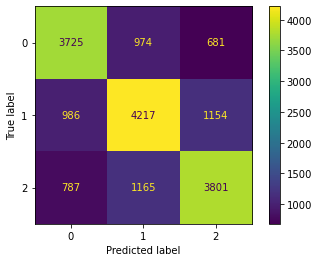

In [33]:
cm = confusion_matrix(y_test_1, predictions_1, labels=rf_sub_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_1.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_1_predictions = rf_sub_1.predict(subgroup_1.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_1['predictions'] = subgroup_1_predictions

In [ ]:
print(sum(rf_sub_1.predict(X_test) == y_test)/len(y_test))

In [ ]:
# subgroup_1.merge(all_subgroups[all_subgroups['subgroup'] == 1], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_1_predictions.csv')

In [ ]:
grid_search.best_params_

In [34]:
subgroup_2_sample = subgroup_2.sample(frac = 0.3)

In [35]:
#subgroup 2
X = subgroup_2_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_2_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_2 = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  600)
rf_sub_2.fit(X_train, y_train)
predictions_2 = rf_sub_2.predict(X_test)
y_test_2 = y_test
print(sum(rf_sub_2.predict(X_test) == y_test)/len(y_test))

0.5878850634222107


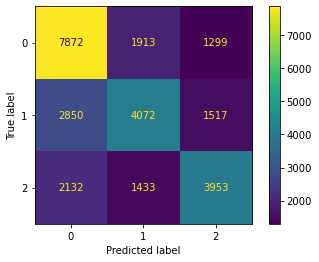

In [36]:
cm = confusion_matrix(y_test_2, predictions_2, labels=rf_sub_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_2.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_2_predictions = rf_sub_2.predict(subgroup_2.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_2['predictions'] = subgroup_2_predictions

In [ ]:
print(sum(rf_sub_2.predict(X_test) == y_test)/len(y_test))

In [ ]:
subgroup_2_return_df = subgroup_2.merge(all_subgroups[all_subgroups['subgroup'] == 2], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [ ]:
# subgroup_2_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_2_predictions.csv')

In [37]:
subgroup_3_sample = subgroup_3.sample(frac = 0.5)

In [38]:
#subgroup 3
X = subgroup_3_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_3_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_3 = RandomForestClassifier(bootstrap = True,
 max_depth = 100,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  600)
rf_sub_3.fit(X_train, y_train)
predictions_3 = rf_sub_3.predict(X_test)
y_test_3 = y_test
print(sum(rf_sub_3.predict(X_test) == y_test)/len(y_test))

0.686750944015761


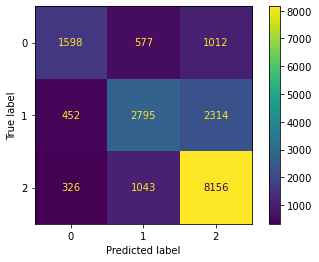

In [39]:
cm = confusion_matrix(y_test_3, predictions_3, labels=rf_sub_3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_3.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_3_predictions = rf_sub_3.predict(subgroup_3.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_3['predictions'] = subgroup_3_predictions

In [ ]:
print(sum(rf_sub_3.predict(X_test) == y_test)/len(y_test))

In [ ]:
subgroup_3_return_df = subgroup_3.merge(all_subgroups[all_subgroups['subgroup'] == 3], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [ ]:
# subgroup_3_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_3_predictions.csv')

In [40]:
subgroup_4_sample = subgroup_4.sample(frac = 0.2)

In [ ]:
subgroup_4_sample

In [41]:
#subgroup 4
X = subgroup_4_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_4_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_4 = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_4.fit(X_train, y_train)
predictions_4 = rf_sub_4.predict(X_test)
y_test_4 = y_test
print(sum(rf_sub_4.predict(X_test) == y_test)/len(y_test))

0.6067381316998468


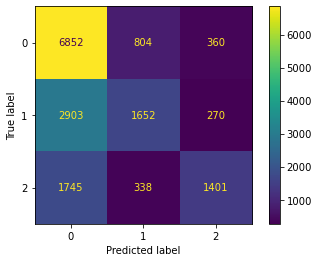

In [42]:
cm = confusion_matrix(y_test_4, predictions_4, labels=rf_sub_4.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_4.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_4_predictions = rf_sub_4.predict(subgroup_4.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_4['predictions'] = subgroup_4_predictions

In [ ]:
print(sum(rf_sub_4.predict(X_test) == y_test)/len(y_test))

In [ ]:
subgroup_4_return_df = subgroup_4.merge(all_subgroups[all_subgroups['subgroup'] == 4], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [ ]:
subgroup_4

In [ ]:
# subgroup_4_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_4_predictions.csv')

In [49]:
subgroup_5_sample = subgroup_5.sample(frac = 0.4)


In [50]:
#subgroup 5
X = subgroup_5_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_5_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_5 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_5.fit(X_train, y_train)
predictions_5 = rf_sub_5.predict(X_test)
y_test_5 = y_test
print(sum(rf_sub_5.predict(X_test) == y_test)/len(y_test))





0.6817413355874894


In [ ]:
subgroup_5_predictions = rf_sub_5.predict(subgroup_5.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

subgroup_5['predictions'] = subgroup_5_predictions

subgroup_5_return_df = subgroup_5.merge(all_subgroups[all_subgroups['subgroup'] == 5], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

subgroup_5_return_df

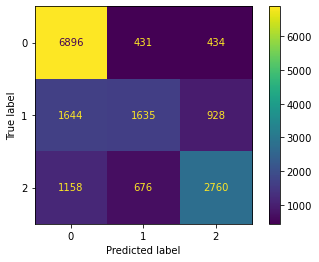

In [51]:
cm = confusion_matrix(y_test_5, predictions_5, labels=rf_sub_5.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_5.classes_)
disp.plot()

plt.show()

In [ ]:
# subgroup_5_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_5_predictions.csv')

In [52]:
subgroup_6_sample = subgroup_6.sample(frac = 0.4)

In [53]:
#subgroup 6 
X = subgroup_6_sample.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_6_sample['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_6 = RandomForestClassifier(bootstrap = True,
 max_depth = 500,
 max_features =  'sqrt',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_6.fit(X_train, y_train)
predictions_6 = rf_sub_6.predict(X_test)
y_test_6 = y_test
print(sum(rf_sub_6.predict(X_test) == y_test)/len(y_test))

0.6464834405401095


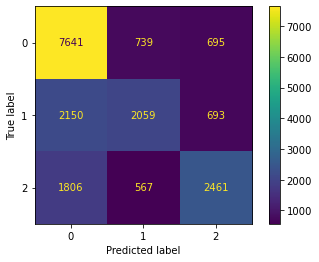

In [54]:
cm = confusion_matrix(y_test_6, predictions_6, labels=rf_sub_6.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_6.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_6_predictions = rf_sub_6.predict(subgroup_6.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_6['predictions'] = subgroup_6_predictions

In [ ]:
subgroup_6_return_df = subgroup_6.merge(all_subgroups[all_subgroups['subgroup'] == 6], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [ ]:
# subgroup_6_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_6_predictions.csv')

In [ ]:
subgroup_7_sample =subgroup_7.sample(frac = 0.9)

In [24]:
#subgroup 7 
X = subgroup_7.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']]
y = subgroup_7['group']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_sub_7 = RandomForestClassifier(bootstrap = True,
 max_depth = 1000,
 max_features =  'auto',
 min_samples_leaf =  1,
 min_samples_split = 5,
 n_estimators =  1000)
rf_sub_7.fit(X_train, y_train)
predictions_7 = rf_sub_7.predict(X_test)
y_test_7 = y_test
print(sum(rf_sub_7.predict(X_test) == y_test)/len(y_test))

0.624728085131401


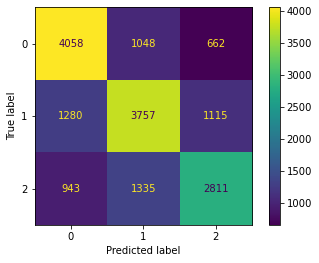

In [25]:
cm = confusion_matrix(y_test_7, predictions_7, labels=rf_sub_7.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf_sub_7.classes_)
disp.plot()

plt.show()

In [ ]:
subgroup_7_predictions = rf_sub_7.predict(subgroup_7.iloc[:,:-1][['Final_Temperature_F', 'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'Combined_Blood_Pressure', 'hadm_number', 'hours_in_hospital', 'rounded_age']])

In [ ]:
subgroup_7['predictions'] = subgroup_7_predictions

In [ ]:
subgroup_7_return_df = subgroup_7.merge(all_subgroups[all_subgroups['subgroup'] == 7], on = ['hadm_id' , 'subject_id', 'rounded_age'], how = 'left').drop_duplicates()

In [ ]:
# subgroup_7_return_df[['subject_id', 'hadm_id', 'subgroup_x', 'rounded_age',
#        'Combined_Blood_Pressure', 'charttime', 'Final_Temperature_F',
#        'heart_rate', 'RespiratoryRate_combined', 'SpO2', 'date', 'hadm_number',
#        'hours_in_hospital', 'sofa', 'group', 'predictions','congestive_heart_failure',
#        'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
#        'peripheral_vascular', 'hypertension', 'paralysis',
#        'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
#        'diabetes_complicated', 'hypothyroidism', 'renal_failure',
#        'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
#        'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
#        'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
#        'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
#        'drug_abuse', 'psychoses', 'depression']].to_csv('subgroup_7_predictions.csv')